In [1]:
%load_ext autoreload
%autoreload 2

from artfinder import load_csv
import pandas as pd
import re
import logging
from typing import cast

logging.basicConfig(level=logging.INFO)

Load data

In [2]:
df = load_csv('database/processed/kabashin_full.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   publisher               251 non-null    string        
 1   license                 149 non-null    object        
 2   is_referenced_by_count  251 non-null    int64         
 3   link                    203 non-null    object        
 4   authors                 251 non-null    object        
 5   abstract                78 non-null     string        
 6   title                   251 non-null    string        
 7   doi                     251 non-null    string        
 8   type                    251 non-null    string        
 9   journal                 247 non-null    string        
 10  issn                    210 non-null    string        
 11  volume                  206 non-null    string        
 12  issue                   169 non-null    string    

Get some information, which can be usefull for filtering data

In [3]:
# Check types of data entries
df['type'].unique()

<StringArray>
['proceedings-article', 'journal-article', 'book-chapter', 'posted-content']
Length: 4, dtype: string

In [4]:
# Check for duplicates
print(df['doi'].duplicated().sum())
df.drop_duplicates(subset=['doi'], inplace=True)

0


Actually filter articles

In [5]:
# Ablation articles
df_abl = df[df['ablation'] == True]
# correct articles types
df_abl = df_abl[df_abl['type'].isin(['journal-article', 'proceedings-article'])]
# Articles after 1993
df_abl = df_abl[df_abl['publication_date'] > '1993']
# reindex
df_abl.reset_index(drop=True, inplace=True)
df_abl.info()
df_abl = cast(pd.DataFrame, df_abl)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   publisher               145 non-null    string        
 1   license                 91 non-null     object        
 2   is_referenced_by_count  145 non-null    int64         
 3   link                    117 non-null    object        
 4   authors                 145 non-null    object        
 5   abstract                52 non-null     string        
 6   title                   145 non-null    string        
 7   doi                     145 non-null    string        
 8   type                    145 non-null    string        
 9   journal                 145 non-null    string        
 10  issn                    125 non-null    string        
 11  volume                  121 non-null    string        
 12  issue                   99 non-null     string    

Get distribution of publications by year

<Axes: title={'center': 'Publications by Year'}, xlabel='Year', ylabel='Count'>

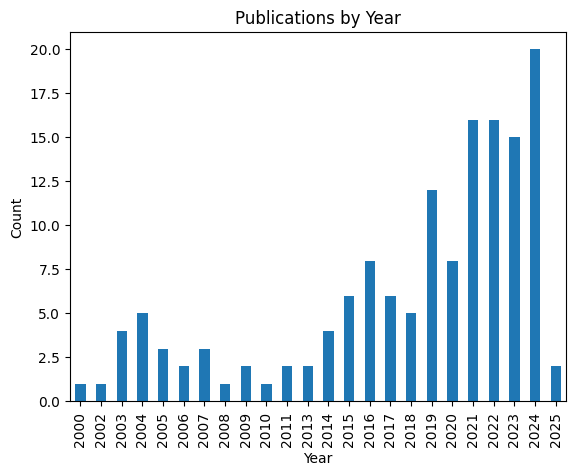

In [6]:
df_cleaned = df_abl.dropna(subset=['publication_date'])
df_cleaned.groupby(df_cleaned['publication_date'].dt.year)['doi'].count().plot.bar(xlabel='Year', ylabel='Count', title='Publications by Year')

Get statistics on publication types

<Axes: title={'center': 'Publications by Type'}, xlabel='Type', ylabel='Count'>

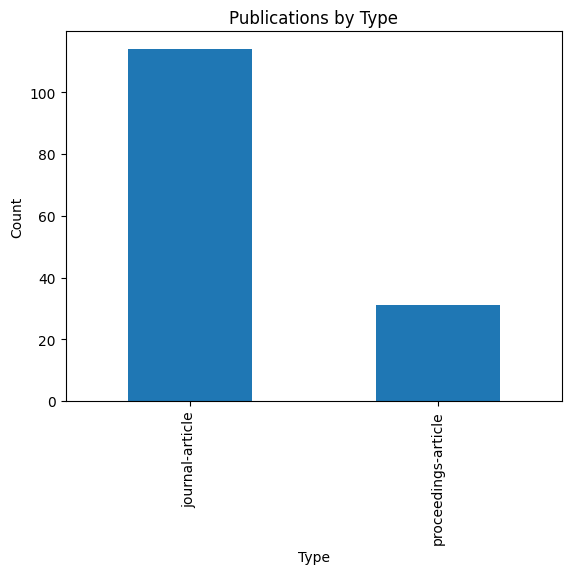

In [7]:
df_abl.groupby('type')['doi'].count().plot.bar(xlabel='Type', ylabel='Count', title='Publications by Type')

Get basic statistic about words from title

In [8]:
display((df_abl[df_abl['ablation']]['title'].map(lambda x: re.findall(r'\b\w{1,3}\b', x)).explode().unique()))
df_abl[df_abl['ablation']]['title'].map(lambda x: re.findall(r'\b\w{4,}\b', x, flags=re.IGNORECASE)).explode().value_counts().head(10)

array(['of', 'for', 'and', 'in', 'a', 'to', 'non', 'si', 'au', 'tin',
       'as', 'two', 'the', 'by', 'on', 'air', 'peo', 'wet', 'its', 'via',
       'an', 'gas', 'due', nan, 'cis', 'at', 'nps', 'ni', 'bi', 'x',
       'ray', 'low', 'sup', '68', 'ga', 'pbs', 'zrn', 'sm', 'fe', 'hfn',
       'ir'], dtype=object)

title
laser            104
nanoparticles    101
ablation          44
synthesized       34
gold              33
synthesis         29
applications      27
femtosecond       26
based             23
plasmonic         18
Name: count, dtype: int64

Check how many articles have *nano* in them and print those, who don't

In [9]:
nps = df_abl[df_abl['title'].str.contains(r'\b\w*nano\w*\b')]
print('Articles with nanp:', nps['doi'].count())
df_abl[~df_abl['doi'].isin(nps['doi'])][['title', 'abstract']]

Articles with nanp: 138


,title,abstract
3,femtosecond laser ablation in aqueous solution...,<NA>
39,processing of metals and semiconductors by a f...,<NA>
42,laser-ablative synthesis and photoheating char...,<NA>
54,laser-ablative synthesis of aggregation-induce...,<NA>
92,graphene–gold metasurface architectures for ul...,<NA>
108,laser-synthesized oxide-passivated bright si q...,crystalline silicon (si) nanoparticles present...
114,manipulating the optically active defect–defec...,<NA>


Check how many articles have *nano* or *laser* in their title and print those, who don't

In [10]:
nps_laser = df_abl[df_abl['title'].str.contains(r'\b\w*nano\w*\b|\b\w*laser\w*\b')]
print('Articles with nanp:', nps_laser['doi'].count())
df_abl[~df_abl['doi'].isin(nps_laser['doi'])][['title', 'abstract']]

Articles with nanp: 143


,title,abstract
92,graphene–gold metasurface architectures for ul...,<NA>
114,manipulating the optically active defect–defec...,<NA>


It seems like good filter cound contain following restrictions:
* Publication date > 1993
* Publication type *jurnal_article* or *proceedings_article*
* Title contains *nano* or *laser*